In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Bidirectional
from keras.models import Sequential

from sklearn import linear_model 
from sklearn.metrics import mean_absolute_error
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Using TensorFlow backend.


In [2]:
df = pd.read_csv('Equites_Historical_NonAdjusted_Prices.csv',usecols=['Industry Group', 'Symbol', 'Company Name', 'Date', 'Open', 'High',
       'Low', 'Close', 'Change', '% Change', 'Volume Traded',
       'Value Traded (SAR)', 'No. of Trades'])

In [3]:
df.Date = pd.to_datetime(df.Date, dayfirst=True)

In [4]:
df.sort_values('Date',inplace=True)

In [5]:
Riyad_Bank = df[df['Company Name']== 'Riyad Bank']

In [6]:
Riyadhb_for_model = Riyad_Bank[['Date','Open', 'High', 'Low',
       'Close', 'Change']]

In [7]:
Riyadhb_for_model.reset_index(inplace=True)

In [8]:
window_len = 30

#Create a data point (i.e. a date) which splits the training and testing set
split_date = list(Riyadhb_for_model["Date"][-(2*window_len+1):])[0]

In [9]:
training_set, test_set = Riyadhb_for_model[Riyadhb_for_model['Date'] < split_date], Riyadhb_for_model[Riyadhb_for_model['Date'] >= split_date]
training_set = training_set.drop('index', 1)
test_set = test_set.drop('index', 1)

In [10]:
training_set.set_index('Date',inplace=True)

In [11]:
test_set.set_index('Date',inplace=True)

In [12]:
testing = test_set.as_matrix()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [13]:
training = training_set.as_matrix()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [14]:
training_set.shape

(2661, 5)

In [15]:
LSTM_training_inputs = []
for i in range(len(training)-window_len):
    temp_set = training[i:(i+window_len)].copy()
    
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = training_set[ 'Close'][window_len:].values
# LSTM_training_outputs = np.reshape(LSTM_training_outputs, (len(LSTM_training_outputs),1,1))


LSTM_training_inputs = np.array(LSTM_training_inputs)
# LSTM_training_inputs = np.reshape(LSTM_training_inputs,(len(LSTM_training_inputs),window_len,1))

#Create windows for testing
LSTM_test_inputs = []
for i in range(len(testing)-window_len):
    temp_set1 = testing[i:(i+window_len)].copy()
    
    
    LSTM_test_inputs.append(temp_set1)
LSTM_test_outputs = test_set['Close'][window_len:].values


LSTM_test_inputs = np.array(LSTM_test_inputs)
# LSTM_test_inputs = np.reshape(LSTM_test_inputs,(len(LSTM_test_inputs),window_len,1))

In [16]:
def build_model(inputs, output_size, neurons, activ_func="relu",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [17]:
def get_train_length(dataset, batch_size, test_percentage):
    length = len(dataset)
    length *= 1 - test_percentage
    train_length_values = []
    for x in range(int(length) - 100, int(length)):
        modulo = x % batch_size
        if modulo == 0 :
            train_length_values.append(x)
            print(x)
    return (max(train_length_values))

In [18]:
len(Riyadhb_for_model)

2722

In [19]:
len(Riyadhb_for_model)-(2722*.2)

2177.6

In [20]:
get_train_length(Riyadhb_for_model,64,0.2)

2112
2176


2176

In [21]:
nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 250)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=100, batch_size=64, verbose=1,validation_split= 0.2,)

Train on 2104 samples, validate on 527 samples
Epoch 1/100
2104/2104 [==============================] - 2s 1ms/step - loss: 14.9799 - val_loss: 4.4333
Epoch 2/100
2104/2104 [==============================] - 2s 939us/step - loss: 6.0557 - val_loss: 5.4660
Epoch 3/100
2104/2104 [==============================] - 2s 948us/step - loss: 3.9817 - val_loss: 2.7327
Epoch 4/100
2104/2104 [==============================] - 2s 968us/step - loss: 1.6630 - val_loss: 0.5504
Epoch 5/100
2104/2104 [==============================] - 2s 1ms/step - loss: 0.8880 - val_loss: 0.3803
Epoch 6/100
2104/2104 [==============================] - 2s 1ms/step - loss: 0.8254 - val_loss: 0.3681
Epoch 7/100
2104/2104 [==============================] - 2s 1ms/step - loss: 0.7707 - val_loss: 0.4008
Epoch 8/100
2104/2104 [==============================] - 2s 1ms/step - loss: 0.7158 - val_loss: 0.2416
Epoch 9/100
2104/2104 [==============================] - 2s 1ms/step - loss: 0.6748 - val_loss: 0.2444
Epoch 10/100
2104/2

2104/2104 [==============================] - 2s 1ms/step - loss: 0.4781 - val_loss: 0.2162
Epoch 80/100
2104/2104 [==============================] - 2s 1ms/step - loss: 0.4734 - val_loss: 0.2109
Epoch 81/100
2104/2104 [==============================] - 2s 1ms/step - loss: 0.4846 - val_loss: 0.2205
Epoch 82/100
2104/2104 [==============================] - 3s 1ms/step - loss: 0.4802 - val_loss: 0.2092
Epoch 83/100
2104/2104 [==============================] - 2s 1ms/step - loss: 0.4960 - val_loss: 0.2006
Epoch 84/100
2104/2104 [==============================] - 2s 1ms/step - loss: 0.4707 - val_loss: 0.2208
Epoch 85/100
2104/2104 [==============================] - 2s 1ms/step - loss: 0.4831 - val_loss: 0.2100
Epoch 86/100
2104/2104 [==============================] - 2s 1ms/step - loss: 0.4817 - val_loss: 0.2272
Epoch 87/100
2104/2104 [==============================] - 3s 1ms/step - loss: 0.4736 - val_loss: 0.2069
Epoch 88/100
2104/2104 [==============================] - 3s 1ms/step - loss:

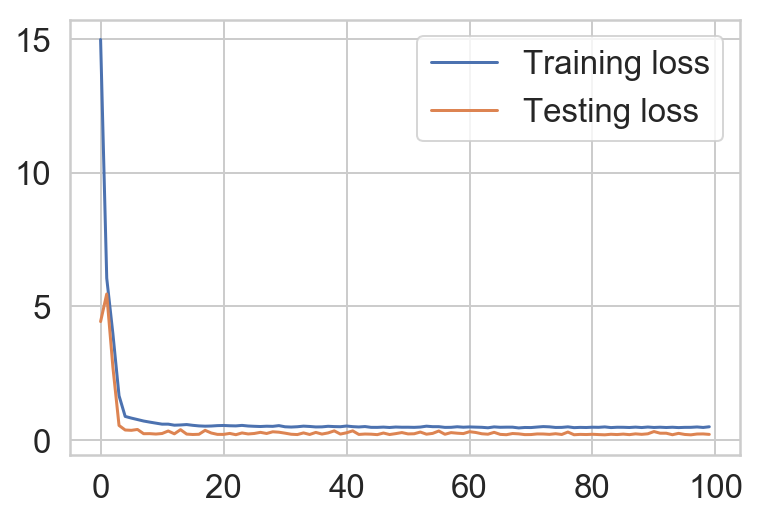

In [22]:
train_loss = nn_history.history['loss']
test_loss = nn_history.history['val_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.legend()

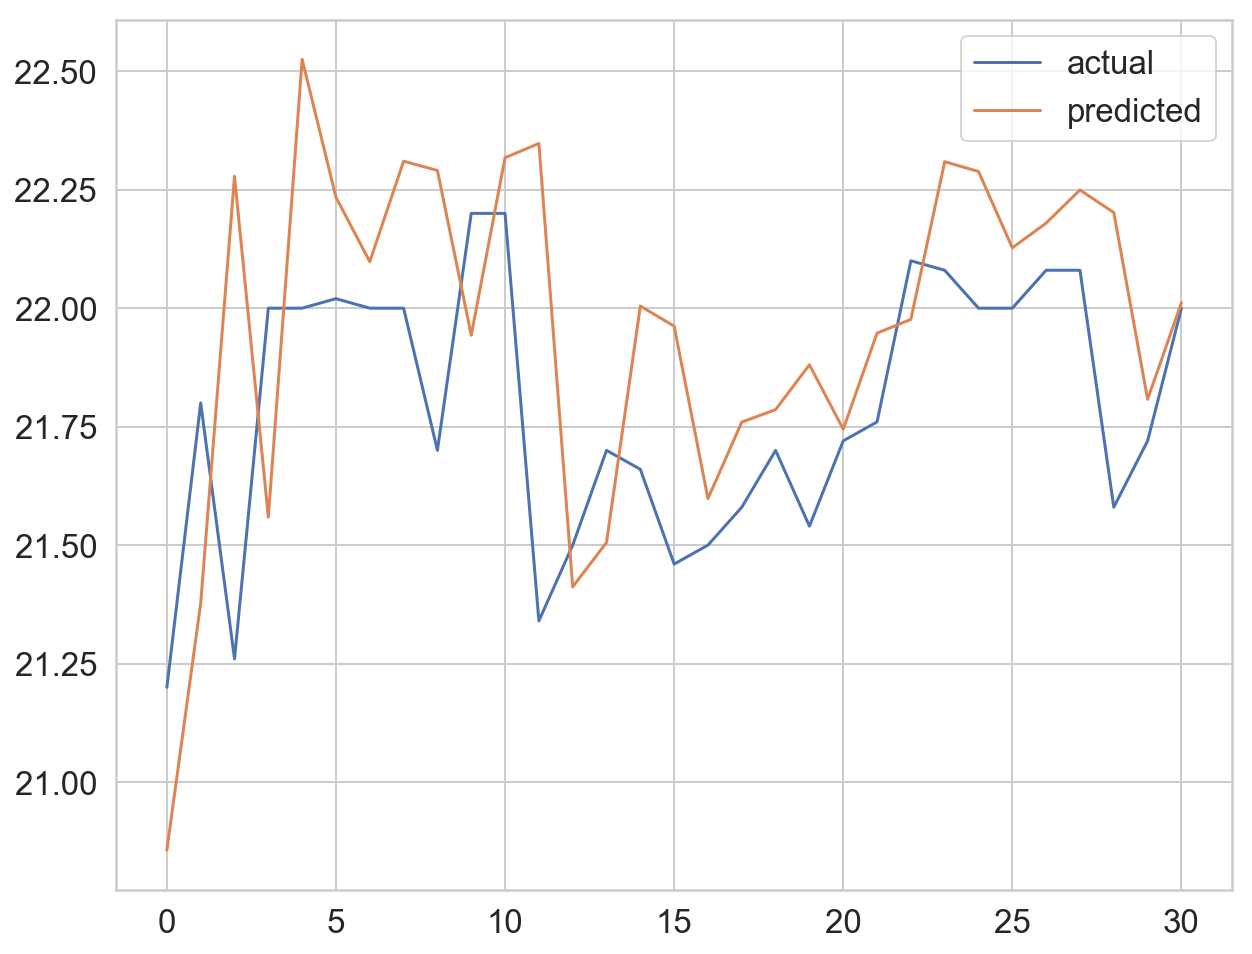

The Mean Absolute Error is: 0.2951189324163625


In [23]:
fig = plt.subplots( figsize=(10,8))
plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
plt.legend()
plt.show()
MAE = mean_absolute_error(LSTM_test_outputs, nn_model.predict(LSTM_test_inputs))
print('The Mean Absolute Error is: {}'.format(MAE))


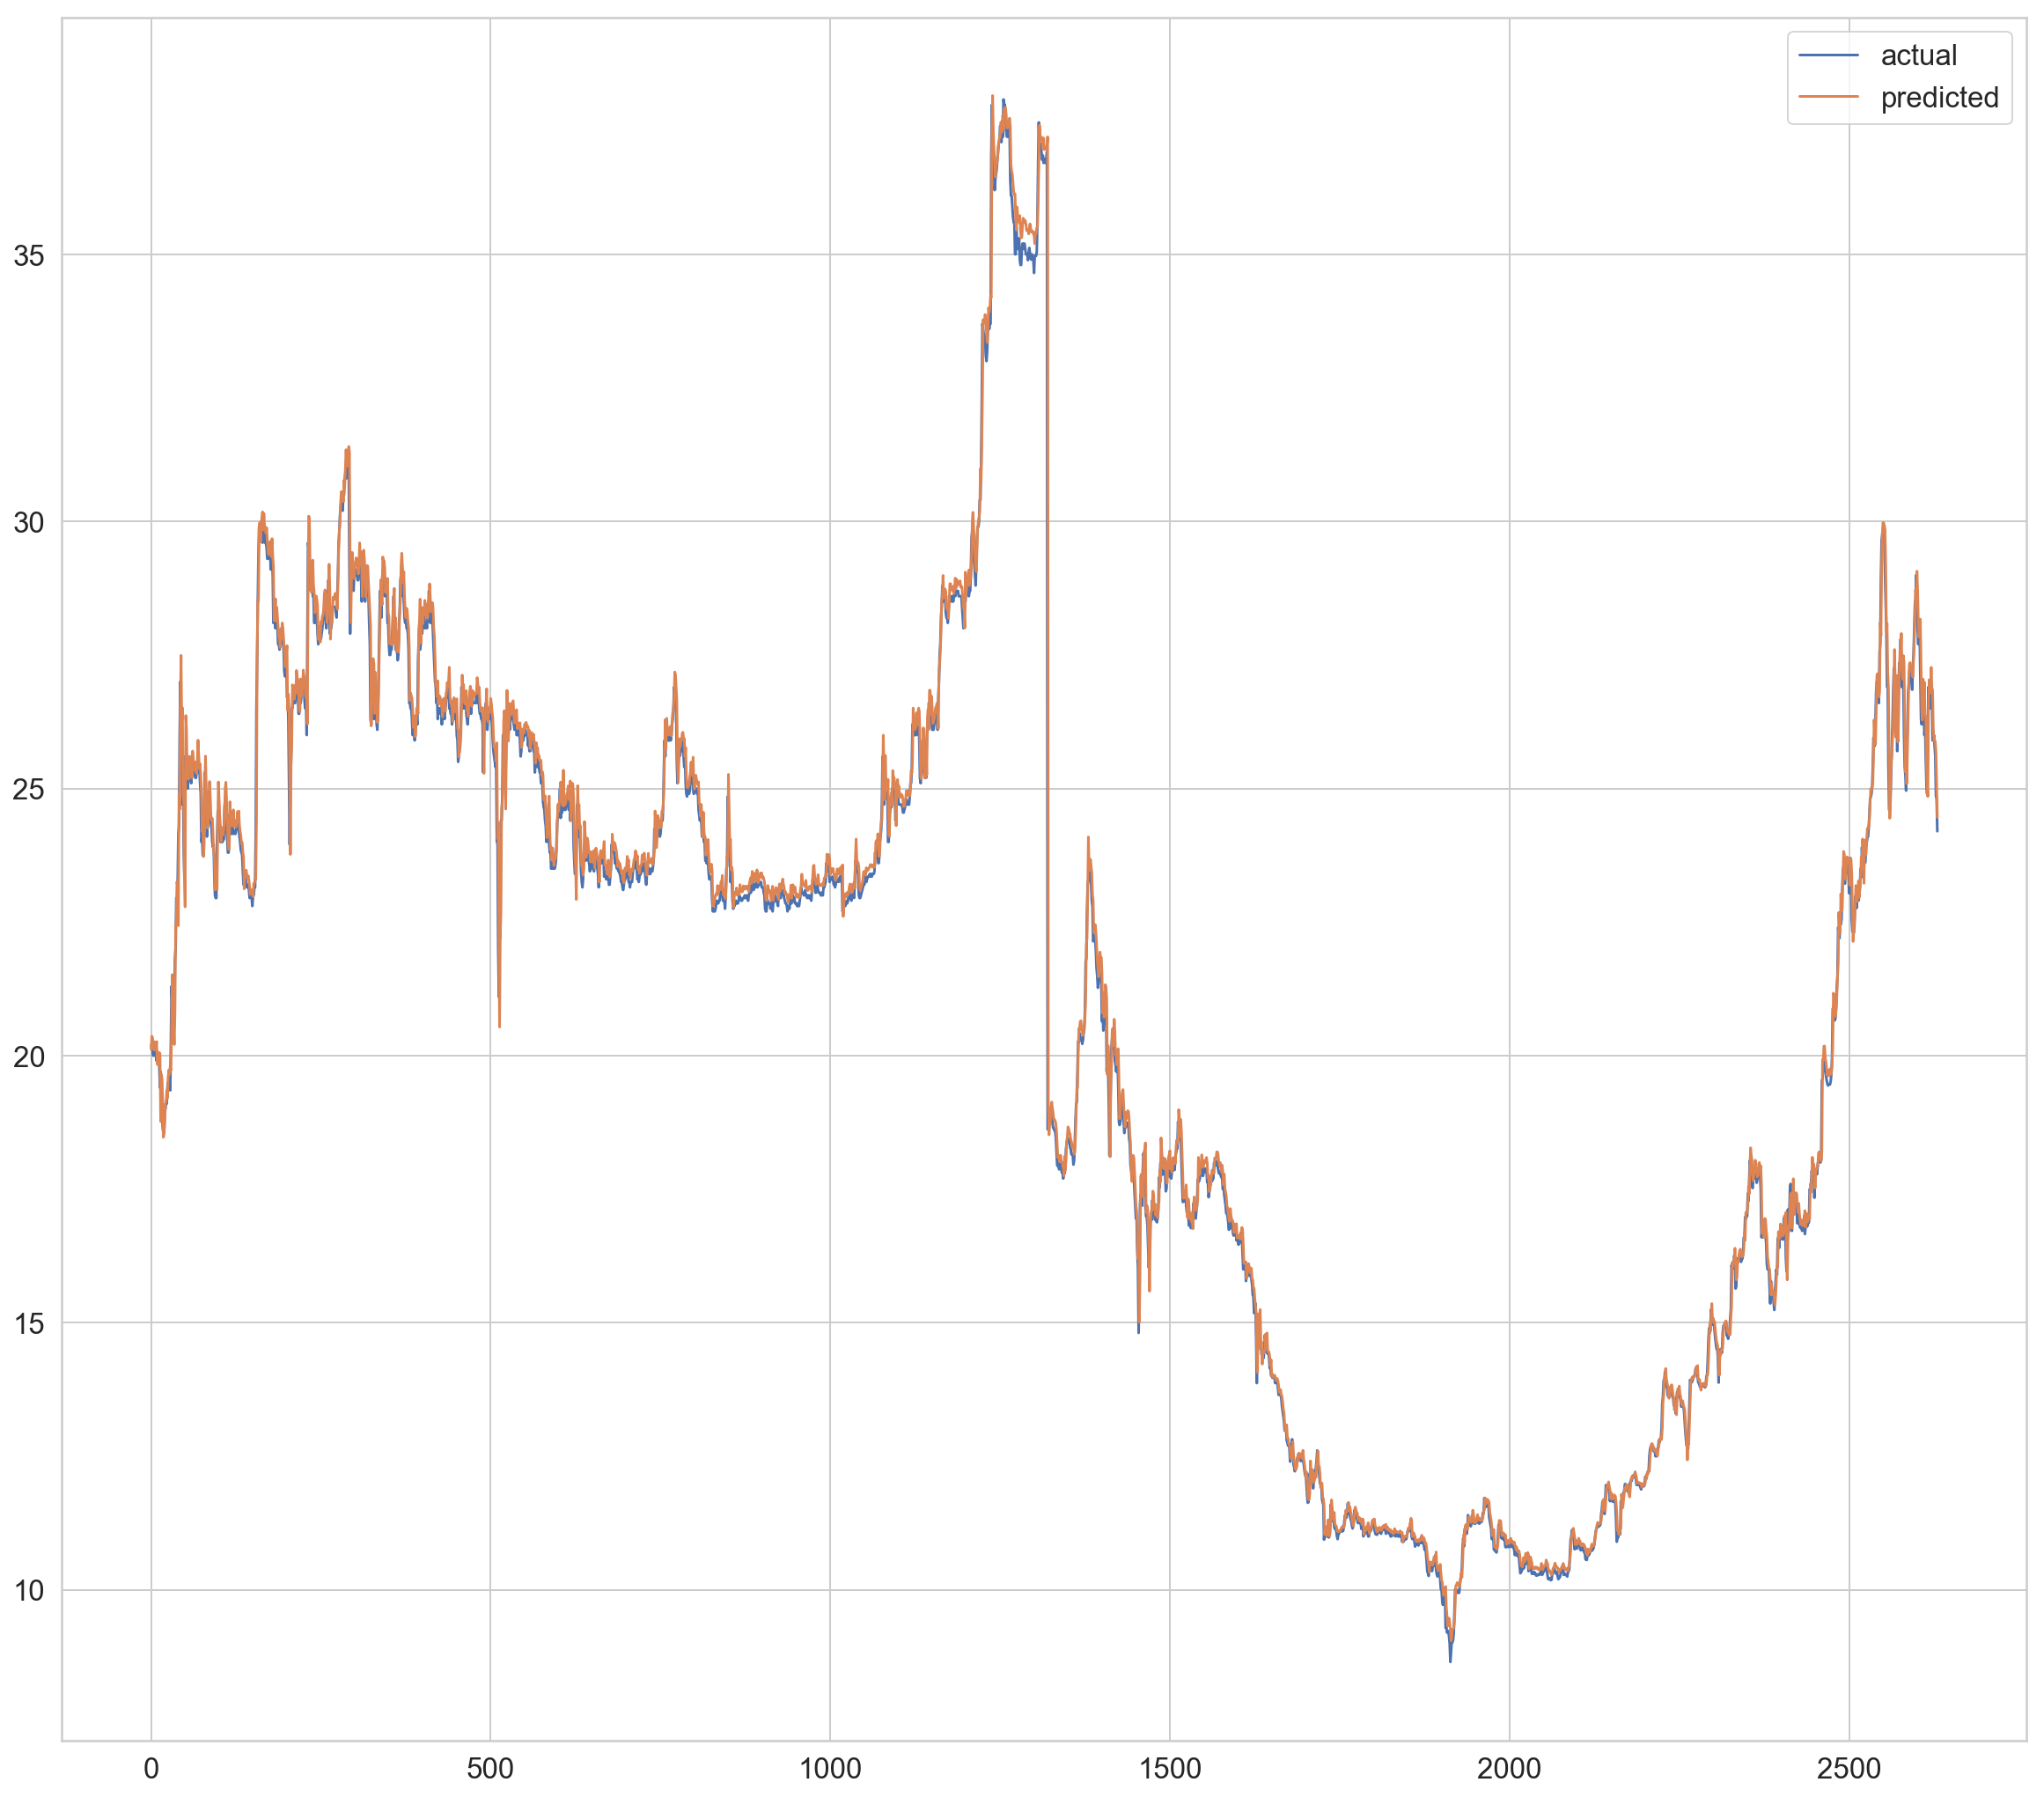

The Mean Absolute Error is: 0.24055017231354375


In [24]:
fig = plt.subplots( figsize=(20,18))
plt.plot(LSTM_training_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_training_inputs), label = "predicted")
plt.legend()
plt.show()
MAE = mean_absolute_error(LSTM_training_outputs, nn_model.predict(LSTM_training_inputs))
print('The Mean Absolute Error is: {}'.format(MAE))